In [1]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import json
import datetime

# DB Schema

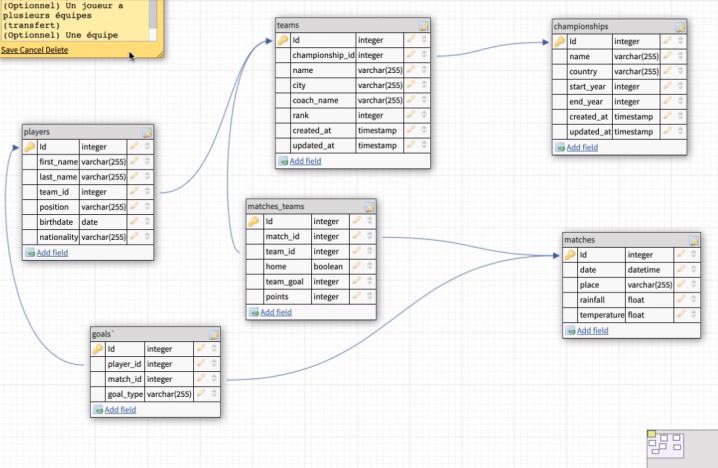

In [2]:
#view df extract and nb rows and nb columns
# return none

def view_df(df):
    display(df.head(3))
    display(df.shape)

# DataFrames

## create df_matches

In [3]:
url = "https://www.lequipe.fr/Football/ligue-1/saison-2020-2021/page-calendrier-resultats"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

json_list = [(i['value']) for i in soup.find(class_='SelectNav__select')]

dico = {
    'date': [],
    'lieu': [],
    'team_domicile': [],
    'team_exterieur': [],
    'score_domicile': [],
    'score_exterieur': [],
    'lien_detail': []
}

for journee in json_list:
    
    response = requests.get(journee)
    data = json.loads(response.text)
    
    for day in data['items'][:-1]:
        
        for game in day['items']:
            

            dico["lieu"].append(game['event']['lieu']['ville'])
            dico["date"].append(datetime.datetime.strptime(game['date'].split('+')[0], "%Y-%m-%dT%H:%M:%S"))
            dico["team_domicile"].append(game['event']['specifics']['domicile']['equipe'][
                'nom'])
            dico["team_exterieur"].append(game['event']['specifics']['exterieur']['equipe'][
                'nom'])
            dico["score_domicile"].append(game['event']['specifics']['score']['domicile'])
            dico["score_exterieur"].append(game['event']['specifics']['score']['exterieur'])
            dico["lien_detail"].append(game['event']['lien_web'])
            
df_matches = pd.DataFrame(dico)


In [4]:
view_df(df_matches)

,date,lieu,team_domicile,team_exterieur,score_domicile,score_exterieur,lien_detail
0,2020-08-21 19:00:00,Bordeaux,Bordeaux,Nantes,0,0,https://www.lequipe.fr/Football/match-direct/l...
1,2020-08-22 17:00:00,Dijon,Dijon,Angers,0,1,https://www.lequipe.fr/Football/match-direct/l...
2,2020-08-22 21:00:00,Lille,Lille,Rennes,1,1,https://www.lequipe.fr/Football/match-direct/l...


(380, 7)

## create df_teams

In [5]:
#Table teams & players

url = "https://www.lequipe.fr/Football/ligue-1/page-participants"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

clubs = soup.find(class_='clubs').find_all('h2')
name_clubs = [i.a['title'].replace('Fiche équipe du ','').replace('Fiche équipe de ','').replace("l'","") for i in clubs]
href_clubs = [i.a['href'] for i in clubs]
city_clubs = [i.a.text.replace(' ','') for i in clubs]
df_clubs = pd.DataFrame({'Name_club':name_clubs, 'city_club':city_clubs, 'href_club':href_clubs,})

In [6]:
view_df(df_clubs)

,Name_club,city_club,href_club
0,SCO Angers,Angers,/Football/FootballFicheClub374.html
1,Bordeaux,Bordeaux,/Football/FootballFicheClub18.html
2,Brest,Brest,/Football/FootballFicheClub267.html


(20, 3)

## create df_players

In [7]:
df_players = pd.DataFrame()
coach_clubs = []

for name, href in zip(df_clubs['city_club'],df_clubs['href_club']):
    url = 'https://www.lequipe.fr'+href
    a = pd.read_html(url)
    b = 2 if (len(a[2]) > 10) else 1
    df_players = df_players.append(a[b].assign(teams = name).drop('Unnamed: 0', axis = 1))
    coach_clubs.append(a[0].iloc[3,0].replace('Entraineur\xa0:','').replace('Entraineur :',''))
                
df_clubs['coaches'] = coach_clubs

In [8]:
view_df(df_players)

,Nom,Pays,Né le,Pos.,teams
0,P. Bernardoni,FRA,18/04/97,Gar.,Angers
1,L. Butelle,FRA,3/04/83,Gar.,Angers
2,D. Petkovic,MNE,25/05/93,Gar.,Angers


(628, 5)

## create df_buteurs

In [9]:
df_buteurs = pd.DataFrame({    
    'buteur':[],    
    'equipe':[],
    'date':[],
    'lieu':[]
})

for url,day,localisation in zip(df_matches.lien_detail, df_matches.date, df_matches.lieu):
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    tab_score = soup.find_all(class_= 'grid__content Scoreboard__goalList')

    if len(tab_score) > 0: 

        buteur_dom = [i.find_all('span')[1].text for i in tab_score[0].find_all(class_= 'Scoreboard__goals')]
        buteur_ext = [i.find_all('span')[1].text for i in tab_score[1].find_all(class_= 'Scoreboard__goals')]

        if len(buteur_dom) > 0:
            for i in buteur_dom:
                buteur_dom = {         
                'buteur':i,
                'equipe':soup.find_all(class_= 'TeamScore__name')[0].text.split()[0],
                'date':day,
                'lieu':localisation  
                }

                df_buteurs = df_buteurs.append(buteur_dom, ignore_index = True)

        if len(buteur_ext) > 0:
            for i in buteur_ext:
                buteur_ext = {
                'buteur':i,
                'equipe':soup.find_all(class_= 'TeamScore__name')[1].text.split()[0],
                'date':day,
                'lieu':localisation  
                } 

                df_buteurs = df_buteurs.append(buteur_ext, ignore_index = True)

In [10]:
view_df(df_buteurs)

,buteur,equipe,date,lieu
0,I. Traoré,Angers,2020-08-22 17:00:00,Dijon
1,J. Bamba,Lille,2020-08-22 21:00:00,Lille
2,D. Da Silva,Rennes,2020-08-22 21:00:00,Lille


(1049, 4)

# Create Tables

## functions for tables creation

In [11]:
#create tables
#return None

def create_tables(cursor):

    #championships
    cursor.execute("""
    CREATE TABLE championships(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name VARCHAR(255),
    country VARCHAR(255),
    start_year INTEGER,
    end_year INTEGER
    )
    ;""")

    conn.commit()

    #matches
    cursor.execute("""
    CREATE TABLE matches(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATE,
    place VARCHAR(255),
    rainfall REAL,
    temperature REAL
    )
    ;""")
    conn.commit()

    #teams
    cursor.execute("""
    CREATE TABLE teams(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    championship_id INTEGER,
    name VARCHAR(255),
    city VARCHAR(255),
    coach_name VARCHAR(255),
    rank INTEGER,
    FOREIGN KEY (championship_id)
    REFERENCES championships(id)
    )
    ;""")
    conn.commit()

    #matches_teams
    cursor.execute("""
    CREATE TABLE matches_teams(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    match_id INTEGER,
    team_id INTEGER,
    home INTEGER,
    team_goal INTEGER,
    points INTEGER,
    FOREIGN KEY (match_id)
    REFERENCES matches(id),
    FOREIGN KEY (team_id)
    REFERENCES teams(id)
    )
    ;""")
    conn.commit()

    #players
    cursor.execute("""
    CREATE TABLE players(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name VARCHAR(255),
    last_name VARCHAR(255),
    team_id INTEGER,
    position VARCHAR(255),
    birthday DATE,
    nationality VARCHAR(255),
    FOREIGN KEY (team_id)
    REFERENCES teams(id)
    )
    ;""")
    conn.commit()

    #goals
    cursor.execute("""
    CREATE TABLE goals(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    player_id INTEGER,
    match_id INTEGER,
    goal_type VARCHAR(255),
    FOREIGN KEY (match_id)
    REFERENCES matches(id),
    FOREIGN KEY (player_id)
    REFERENCES players(id)
    )
    ;""")
    conn.commit()

In [12]:
# drop tables
# return None

def drop_tables(cursor):
    
    cursor.execute('DROP TABLE championships;')
    cursor.execute('DROP TABLE matches;')
    cursor.execute('DROP TABLE teams;')
    cursor.execute('DROP TABLE matches_teams;')
    cursor.execute('DROP TABLE players;')
    cursor.execute('DROP TABLE goals;')

## create DB

In [13]:
#Connexion
conn = sqlite3.connect('data.sqlite')
cursor = conn.cursor()

## create tables

In [14]:
drop_tables(cursor)
create_tables(cursor)

# Fill DB

## functions for db filling

In [15]:
#functions

# view tables
# return none

def view_table(table):
    df_db = pd.read_sql_query(f"""
    SELECT *
    FROM {table}
    ;""", conn)
    display(df_db.head(3))
    display(df_db.shape)


#check id on teams table
#return id

def city_return_id(city):
    df_db = pd.read_sql_query(f"""
    SELECT id
    FROM Teams
    WHERE city = "{city}"
    ;""", conn)
    return df_db.iloc[0,0]


#check id on players table
#return id

def player_return_id(player):
    df_db = pd.read_sql_query(f"""
    SELECT id
    FROM players
    WHERE last_name = "{player}"
    ;""", conn)
    return df_db.iloc[0,0]


#check id on matches table
#return id

def match_return_id(date, place):
    df_db = pd.read_sql_query(f"""
    SELECT id
    FROM matches
    WHERE date = "{date}"
    AND place = "{place}"
    
    ;""", conn)
    return df_db.iloc[0,0]


#compare score and give championship's points
#return points

def victory(score_1, score_2):
    if score_1 > score_2:
        return 3
    elif score_1 == score_2:
        return 1
    else:
        return 0

## fill championships

In [16]:
#fill championships
cursor.execute("""
INSERT INTO championships(
name,
country,
start_year,
end_year
)
VALUES(
'L1',
'France',
2020,
2021
)
;""")

conn.commit()

In [17]:
view_table('championships')

,id,name,country,start_year,end_year
0,1,L1,France,2020,2021


(1, 5)

## fill teams

In [18]:
#fill teams
for i in range(len(df_clubs)):

    cursor.execute("""
    INSERT INTO teams(
    championship_id,
    name,city,
    coach_name,
    rank) 
    VALUES (?,?,?,?,?)
    """,(
        1,
        df_clubs.iloc[i]['Name_club'],
        df_clubs.iloc[i]['city_club'],
        df_clubs.iloc[i]['coaches'],
        0
    ))

    conn.commit()

In [19]:
view_table('teams')

,id,championship_id,name,city,coach_name,rank
0,1,1,SCO Angers,Angers,Gérald BATICLE,0
1,2,1,Bordeaux,Bordeaux,Jean-Louis GASSET,0
2,3,1,Brest,Brest,Michel DER ZAKARIAN,0


(20, 6)

## prepare players filling

In [20]:
#fill city_id on df_players
df_players['id_teams'] = [city_return_id(df_players.iloc[i]['teams']) for i in range(len(df_players['teams']))]

## fill players

In [21]:
#fill players
for i in range(len(df_players)):

    cursor.execute("""
    INSERT INTO players(
    first_name,
    last_name,
    team_id,
    position,
    birthday,
    nationality) 
    VALUES (?,?,?,?,?,?)
    """,(
        None,
        df_players.iloc[i]['Nom'],
        int(df_players.iloc[i]['id_teams']),
        df_players.iloc[i]['Pos.'],
        df_players.iloc[i][2],
        df_players.iloc[i]['Pays']
    ))

    conn.commit()  

In [22]:
view_table('players')

,id,first_name,last_name,team_id,position,birthday,nationality
0,1,None,P. Bernardoni,1,Gar.,18/04/97,FRA
1,2,None,L. Butelle,1,Gar.,3/04/83,FRA
2,3,None,D. Petkovic,1,Gar.,25/05/93,MNE


(628, 7)

## fill matches

In [23]:
#fill matches
for i in range(len(df_matches)):

    cursor.execute("""
    INSERT INTO matches(
    date,
    place,
    rainfall,
    temperature) 
    VALUES (?,?,?,?)
    """,(
        df_matches.iloc[i]['date'].date(),
        df_matches.iloc[i]['lieu'],
        0,
        0
    ))

    conn.commit()

In [24]:
view_table('matches')

,id,date,place,rainfall,temperature
0,1,2020-08-21,Bordeaux,0.0,0.0
1,2,2020-08-22,Dijon,0.0,0.0
2,3,2020-08-22,Lille,0.0,0.0


(380, 5)

## Add trasfered scoring players on players table

In [25]:
#Take scorer who are not in db
invalid_player = {    
    'name':[],
    'team':[]
}

for i in range(len(df_buteurs['buteur'])):
    
    try:
        player_return_id(df_buteurs['buteur'][i])
        
    except:
        invalid_player['name'].append(df_buteurs['buteur'][i])
        invalid_player['team'].append(df_buteurs['equipe'][i])
        
add_player = pd.DataFrame(invalid_player).drop_duplicates()

#Replace origin team of a player
add_player.iloc[5]['team'] = 'Bordeaux'
add_player = add_player.drop_duplicates()

#create final add dataframe
add_player = add_player.assign(poste = ['Att.','Att.','Att.','Mil.','Att.','Déf.','Déf','Att.','Att.','Mil.','Att.','Def.'])
add_player = add_player.assign(birthday = ['30/11/00','04/06/98','27/12/98','18/08/94','14/12/96','21/06/91','03/10/91','12/07/96','19/12/94','15/02/96','05/01/01','05/03/93'])
add_player = add_player.assign(nationality = ['TGO','FRA','NGA','FRA','BRA','BRA','FRA','FRA','SEN','SRB','PRT','SEN'])

#fill city_id on df_players
add_player['id_teams'] = [city_return_id(add_player.iloc[i]['team']) for i in range(len(add_player['team']))]

add_player

#add on players
for i in range(len(add_player)):

    cursor.execute("""
    INSERT INTO players(
    first_name,
    last_name,
    team_id,
    position,
    birthday,
    nationality) 
    VALUES (?,?,?,?,?,?)
    """,(
        None,
        add_player.iloc[i]['name'],
        int(add_player.iloc[i]['id_teams']),
        add_player.iloc[i]['poste'],
        add_player.iloc[i]['birthday'],
        add_player.iloc[i]['nationality']
    ))

    conn.commit()

In [26]:
view_table('players')

,id,first_name,last_name,team_id,position,birthday,nationality
0,1,None,P. Bernardoni,1,Gar.,18/04/97,FRA
1,2,None,L. Butelle,1,Gar.,3/04/83,FRA
2,3,None,D. Petkovic,1,Gar.,25/05/93,MNE


(640, 7)

## prepare goals filling

In [27]:
#change date() on df_buteurs
df_buteurs['date'] = df_buteurs['date'].map(lambda x: x.date())

#add_id_player on buteurs
df_buteurs['id_player'] = [player_return_id(df_buteurs.iloc[i]['buteur']) for i in range(len(df_buteurs['buteur']))]

#add_id_match on buteurs
df_buteurs['id_match'] = [match_return_id(df_buteurs.iloc[i]['date'], df_buteurs.iloc[i]['lieu']) for i in range(len(df_buteurs['buteur']))]

## fill goals

In [28]:
#fill goals
for i in range(len(df_buteurs)):

    cursor.execute("""
    INSERT INTO goals(
    player_id,
    match_id,
    goal_type) 
    VALUES (?,?,?)
    """,(
        int(df_buteurs.iloc[i]['id_player']),
        int(df_buteurs.iloc[i]['id_match']),
        None
    ))

    conn.commit()    

In [29]:
view_table('goals')

,id,player_id,match_id,goal_type
0,1,12,2,None
1,2,172,3,None
2,3,534,3,None


(1049, 4)

## prepare matches_teams filling

In [30]:
pivot = {
    'match_id':[],
    'team':[],
    'home':[],
    'team_goal':[],
    'points':[]    
}

for i in range(len(df_matches)):
    
    #local line
    pivot['match_id'].append(i+1)
    pivot['team'].append(df_matches.iloc[i]['team_domicile'])
    pivot['home'].append(1)
    pivot['team_goal'].append(df_matches.iloc[i]['score_domicile'])
    pivot['points'].append(victory(df_matches.iloc[i]['score_domicile'], df_matches.iloc[i]['score_exterieur']))
    
    #exterior line
    pivot['match_id'].append(i+1)
    pivot['team'].append(df_matches.iloc[i]['team_exterieur'])
    pivot['home'].append(0)
    pivot['team_goal'].append(df_matches.iloc[i]['score_exterieur'])
    pivot['points'].append(victory(df_matches.iloc[i]['score_exterieur'], df_matches.iloc[i]['score_domicile']))
    
    
df_pivot = pd.DataFrame(pivot)

#add id_teams
df_pivot['id_teams'] = [city_return_id(df_pivot.iloc[i]['team']) for i in range(len(df_pivot['team']))]


## fill matches_teams

In [31]:
#fill matches_teams

for i in range(len(df_matches)):

    cursor.execute("""
    INSERT INTO matches_teams(
    match_id,
    team_id,
    home,
    team_goal,
    points) 
    VALUES (?,?,?,?,?)
    """,(
        int(df_pivot.iloc[i]['match_id']),
        int(df_pivot.iloc[i]['id_teams']),
        int(df_pivot.iloc[i]['home']),
        int(df_pivot.iloc[i]['team_goal']),
        int(df_pivot.iloc[i]['points'])    
    ))

    conn.commit()

In [32]:
view_table('matches_teams')

,id,match_id,team_id,home,team_goal,points
0,1,1,2,1,0,1
1,2,1,13,0,0,1
2,3,2,4,1,0,0


(380, 6)